In [3]:
from utils.stringutils import linewise_tokenize, wordwise_tokenize, string_edit_distance


In [13]:
corpus = '''# Generated by pub
# See https://dart.dev/tools/pub/glossary#lockfile
packages:
  _fe_analyzer_shared:
    dependency: transitive
    description:
      name: _fe_analyzer_shared
      sha256: ae92f5d747aee634b87f89d9946000c2de774be1d6ac3e58268224348cd0101a
      url: "https://pub.dev"
    source: hosted
    version: "61.0.0"
  _flutterfire_internals:
    dependency: transitive
    description:
      name: _flutterfire_internals
      sha256: f5628cd9c92ed11083f425fd1f8f1bc60ecdda458c81d73b143aeda036c35fe7
      url: "https://pub.dev"
    source: hosted
    version: "1.3.16"
  analyzer:
    dependency: transitive
    description:
      name: analyzer
      sha256: ea3d8652bda62982addfd92fdc2d0214e5f82e43325104990d4f4c4a2a313562
      url: "https://pub.dev"
    source: hosted
    version: "5.13.0"
  archive:
    dependency: transitive
    description:
      name: archive
      sha256: "22600aa1e926be775fa5fe7e6894e7fb3df9efda8891c73f70fb3262399a432d"
      url: "https://pub.dev"
    source: hosted
    version: "3.4.10"
  args:
    dependency: transitive
    description:
      name: args
      sha256: eef6c46b622e0494a36c5a12d10d77fb4e855501a91c1b9ef9339326e58f0596
      url: "https://pub.dev"
    source: hosted
    version: "2.4.2"
  assorted_layout_widgets:
    dependency: "direct main"
    description:
      name: assorted_layout_widgets
      sha256: "72893e0de0ba66a97d60ea54fd004f5ca8c13ff856c37adabfcf40a06aa4463f"
      url: "https://pub.dev"
    source: hosted
    version: "8.0.5"
  async:
    dependency: transitive
    description:
      name: async
      sha256: "947bfcf187f74dbc5e146c9eb9c0f10c9f8b30743e341481c1e2ed3ecc18c20c"
      url: "https://pub.dev"
    source: hosted
    version: "2.11.0"
  auth_buttons:
    dependency: "direct main"
    description:
      name: auth_buttons
      sha256: "74b25922d277cd07e159f0be2ee8ef6309ea73d5db2ff04efad95892903870c2"
      url: "https://pub.dev"
    source: hosted
    version: "1.0.1+4"
  boolean_selector:
    dependency: transitive
    description:
      name: boolean_selector
      sha256: "6cfb5af12253eaf2b368f07bacc5a80d1301a071c73360d746b7f2e32d762c66"
      url: "https://pub.dev"
    source: hosted
    version: "2.1.1"
  camera:
    dependency: "direct main"
    description:
      name: camera
      sha256: "9499cbc2e51d8eb0beadc158b288380037618ce4e30c9acbc4fae1ac3ecb5797"
      url: "https://pub.dev"
    source: hosted
    version: "0.10.5+9"
  camera_android:
    dependency: transitive
    description:
      name: camera_android
      sha256: "351429510121d179b9aac5a2e8cb525c3cd6c39f4d709c5f72dfb21726e52371"
      url: "https://pub.dev"
    source: hosted
    version: "0.10.8+16"
  camera_avfoundation:
    dependency: transitive
    description:
      name: camera_avfoundation
      sha256: "608b56b0880722f703871329c4d7d4c2f379c8e2936940851df7fc041abc6f51"
      url: "https://pub.dev"
    source: hosted
    version: "0.9.13+10"
  camera_platform_interface:
    dependency: transitive
    description:
      name: camera_platform_interface
      sha256: e971ebca970f7cfee396f76ef02070b5e441b4aa04942da9c108d725f57bbd32
      url: "https://pub.dev"
    source: hosted
    version: "2.7.2"
  camera_web:
    dependency: transitive
    description:
      name: camera_web
      sha256: "012c82efeb6b69626f1cf7a37c5277c1032428bcae98c7ab6401ff5e91eca628"
      url: "https://pub.dev"
    source: hosted
    version: "0.3.2+2"
  characters:
    dependency: transitive
    description:
      name: characters
      sha256: "04a925763edad70e8443c99234dc3328f442e811f1d8fd1a72f1c8ad0f69a605"
      url: "https://pub.dev"
    source: hosted
    version: "1.3.0"
  clock:
    dependency: transitive
    description:
      name: clock
      sha256: cb6d7f03e1de671e34607e909a7213e31d7752be4fb66a86d29fe1eb14bfb5cf
      url: "https://pub.dev"
    source: hosted
    version: "1.1.1"
  cloud_firestore:
    dependency: "direct main"
    description:
      name: cloud_firestore
      sha256: "8bfbb5a2edbc6052452326d60de0113fea2bcbf081d34a3f8e45c8b38307b31c"
      url: "https://pub.dev"
    source: hosted
    version: "4.14.0"
  cloud_firestore_platform_interface:
    dependency: transitive
    description:
      name: cloud_firestore_platform_interface
      sha256: "73ff438fe46028f0e19f55da18b6ddc6906ab750562cd7d9ffab77ff8c0c4307"
      url: "https://pub.dev"
    source: hosted
    version: "6.1.0"
  cloud_firestore_web:
    dependency: transitive
    description:
      name: cloud_firestore_web
      sha256: "232e45e95970d3a6baab8f50f9c3a6e2838d145d9d91ec9a7392837c44296397"
      url: "https://pub.dev"
    source: hosted
    version: "3.9.0"
  cloud_functions:
    dependency: "direct main"
    description:
      name: cloud_functions
      sha256: "88cf33c79249908461e500c507ccb88fe4ee26755555d837f29ade8eb340c0df"
      url: "https://pub.dev"
    source: hosted
    version: "4.6.0"
  cloud_functions_platform_interface:
    dependency: transitive
    description:
      name: cloud_functions_platform_interface
      sha256: "8e291d2677010fd85021698a3906ef090fd2f53528e2bc1bf45fbe5dbbddf037"
      url: "https://pub.dev"
    source: hosted
    version: "5.5.11"
  cloud_functions_web:
    dependency: transitive
    description:
      name: cloud_functions_web
      sha256: "1d3799204b8b367952bb7ca292bdcec1ed07129b04a8be9f2c298aa77e6f1aa0"
      url: "https://pub.dev"
    source: hosted
    version: "4.6.11"
  collection:
    dependency: transitive
    description:
      name: collection
      sha256: "4a07be6cb69c84d677a6c3096fcf960cc3285a8330b4603e0d463d15d9bd934c"
      url: "https://pub.dev"
    source: hosted
    version: "1.17.1"
  contact_picker_platform_interface:
    dependency: transitive
    description:
      name: contact_picker_platform_interface
      sha256: "40847ffa0f6e6755c0047e8ef35c4b622a2b053f41ef175d22c19f03984a9ed1"
      url: "https://pub.dev"
    source: hosted
    version: "4.7.0"
  contact_picker_web:
    dependency: transitive
    description:
      name: contact_picker_web
      sha256: "13e739a6ce8f3286e441028dec5967b90fd2d5ceaec53045ae054b030877fe31"
      url: "https://pub.dev"
    source: hosted
    version: "4.7.0"
  convert:
    dependency: transitive
    description:
      name: convert
      sha256: "0f08b14755d163f6e2134cb58222dd25ea2a2ee8a195e53983d57c075324d592"
      url: "https://pub.dev"
    source: hosted
    version: "3.1.1"
  cross_file:
    dependency: transitive
    description:
      name: cross_file
      sha256: "2f9d2cbccb76127ba28528cb3ae2c2326a122446a83de5a056aaa3880d3882c5"
      url: "https://pub.dev"
    source: hosted
    version: "0.3.3+7"
  crypto:
    dependency: "direct main"
    description:
      name: crypto
      sha256: ff625774173754681d66daaf4a448684fb04b78f902da9cb3d308c19cc5e8bab
      url: "https://pub.dev"
    source: hosted
    version: "3.0.3"
  csslib:
    dependency: transitive
    description:
      name: csslib
      sha256: "706b5707578e0c1b4b7550f64078f0a0f19dec3f50a178ffae7006b0a9ca58fb"
      url: "https://pub.dev"
    source: hosted
    version: "1.0.0"
  cupertino_icons:
    dependency: "direct main"
    description:
      name: cupertino_icons
      sha256: d57953e10f9f8327ce64a508a355f0b1ec902193f66288e8cb5070e7c47eeb2d
      url: "https://pub.dev"
    source: hosted
    version: "1.0.6"
  curved_navigation_bar:
    dependency: "direct main"
    description:
      name: curved_navigation_bar
      sha256: ea6412d00c5d83501bbf1cf9d1ac2ff11a20fbaf910c103c95ace7de82910334
      url: "https://pub.dev"
    source: hosted
    version: "1.0.3"
  date_format:
    dependency: "direct main"
    description:
      name: date_format
      sha256: "8e5154ca363411847220c8cbc43afcf69c08e8debe40ba09d57710c25711760c"
      url: "https://pub.dev"
    source: hosted
    version: "2.0.7"
  dbus:
    dependency: transitive
    description:
      name: dbus
      sha256: "365c771ac3b0e58845f39ec6deebc76e3276aa9922b0cc60840712094d9047ac"
      url: "https://pub.dev"
    source: hosted
    version: "0.7.10"
  equatable:
    dependency: transitive
    description:
      name: equatable
      sha256: c2b87cb7756efdf69892005af546c56c0b5037f54d2a88269b4f347a505e3ca2
      url: "https://pub.dev"
    source: hosted
    version: "2.0.5"
  fake_async:
    dependency: transitive
    description:
      name: fake_async
      sha256: "511392330127add0b769b75a987850d136345d9227c6b94c96a04cf4a391bf78"
      url: "https://pub.dev"
    source: hosted
    version: "1.3.1"
  ffi:
    dependency: transitive
    description:
      name: ffi
      sha256: "7bf0adc28a23d395f19f3f1eb21dd7cfd1dd9f8e1c50051c069122e6853bc878"
      url: "https://pub.dev"
    source: hosted
    version: "2.1.0"
  file:
    dependency: transitive
    description:
      name: file
      sha256: "5fc22d7c25582e38ad9a8515372cd9a93834027aacf1801cf01164dac0ffa08c"
      url: "https://pub.dev"
    source: hosted
    version: "7.0.0"
  file_selector_linux:
    dependency: transitive
    description:
      name: file_selector_linux
      sha256: "045d372bf19b02aeb69cacf8b4009555fb5f6f0b7ad8016e5f46dd1387ddd492"
      url: "https://pub.dev"
    source: hosted
    version: "0.9.2+1"
  file_selector_macos:
    dependency: transitive
    description:
      name: file_selector_macos
      sha256: b15c3da8bd4908b9918111fa486903f5808e388b8d1c559949f584725a6594d6
      url: "https://pub.dev"
    source: hosted
    version: "0.9.3+3"
  file_selector_platform_interface:
    dependency: transitive
    description:
      name: file_selector_platform_interface
      sha256: a3994c26f10378a039faa11de174d7b78eb8f79e4dd0af2a451410c1a5c3f66b
      url: "https://pub.dev"
    source: hosted
    version: "2.6.2"
  file_selector_windows:
    dependency: transitive
    description:
      name: file_selector_windows
      sha256: d3547240c20cabf205c7c7f01a50ecdbc413755814d6677f3cb366f04abcead0
      url: "https://pub.dev"
    source: hosted
    version: "0.9.3+1"
  firebase_auth:
    dependency: "direct main"
    description:
      name: firebase_auth
      sha256: "279b2773ff61afd9763202cb5582e2b995ee57419d826b9af6517302a59b672f"
      url: "https://pub.dev"
    source: hosted
    version: "4.16.0"
  firebase_auth_platform_interface:
    dependency: transitive
    description:
      name: firebase_auth_platform_interface
      sha256: "3c9cfaccb7549492edf5b0c67c6dd1c6727c7830891aa6727f2fb225f0226626"
      url: "https://pub.dev"
    source: hosted
    version: "7.0.9"
  firebase_auth_web:
    dependency: transitive
    description:
      name: firebase_auth_web
      sha256: c7b1379ccef7abf4b6816eede67a868c44142198e42350f51c01d8fc03f95a7d
      url: "https://pub.dev"
    source: hosted
    version: "5.8.13"
  firebase_core:
    dependency: "direct main"
    description:
      name: firebase_core
      sha256: "96607c0e829a581c2a483c658f04e8b159964c3bae2730f73297070bc85d40bb"
      url: "https://pub.dev"
    source: hosted
    version: "2.24.2"
  firebase_core_platform_interface:
    dependency: transitive
    description:
      name: firebase_core_platform_interface
      sha256: c437ae5d17e6b5cc7981cf6fd458a5db4d12979905f9aafd1fea930428a9fe63
      url: "https://pub.dev"
    source: hosted
    version: "5.0.0"
  firebase_core_web:
    dependency: transitive
    description:
      name: firebase_core_web
      sha256: d585bdf3c656c3f7821ba1bd44da5f13365d22fcecaf5eb75c4295246aaa83c0
      url: "https://pub.dev"
    source: hosted
    version: "2.10.0"
  firebase_database:
    dependency: "direct main"
    description:
      name: firebase_database
      sha256: "8568ad41f9312ab1f162f70c1e3e7cb7420b8bc8d07e4d543e575bb0cb41f8a5"
      url: "https://pub.dev"
    source: hosted
    version: "10.4.0"
  firebase_database_platform_interface:
    dependency: transitive
    description:
      name: firebase_database_platform_interface
      sha256: "4366ade2390f8799a317bb13af29c2a1fdfc84f4d04372094756b86a6cbfd305"
      url: "https://pub.dev"
    source: hosted
    version: "0.2.5+16"
  firebase_database_web:
    dependency: transitive
    description:
      name: firebase_database_web
      sha256: "4920a83b917493b37fd408cbb01c289ef8a422d9ed48982f908a9850290262f9"
      url: "https://pub.dev"
    source: hosted
    version: "0.2.3+16"
  firebase_messaging:
    dependency: "direct main"
    description:
      name: firebase_messaging
      sha256: "980259425fa5e2afc03e533f33723335731d21a56fd255611083bceebf4373a8"
      url: "https://pub.dev"
    source: hosted
    version: "14.7.10"
  firebase_messaging_platform_interface:
    dependency: transitive
    description:
      name: firebase_messaging_platform_interface
      sha256: "54e283a0e41d81d854636ad0dad73066adc53407a60a7c3189c9656e2f1b6107"
      url: "https://pub.dev"
    source: hosted
    version: "4.5.18"
  firebase_messaging_web:
    dependency: transitive
    description:
      name: firebase_messaging_web
      sha256: "90dc7ed885e90a24bb0e56d661d4d2b5f84429697fd2cbb9e5890a0ca370e6f4"
      url: "https://pub.dev"
    source: hosted
    version: "3.5.18"
  firebase_remote_config:
    dependency: "direct main"
    description:
      name: firebase_remote_config
      sha256: "60fc92273d1db338a6fad1839c42dedc4ad64f812043acad0cbb200702f5c9ce"
      url: "https://pub.dev"
    source: hosted
    version: "4.3.8"
  firebase_remote_config_platform_interface:
    dependency: transitive
    description:
      name: firebase_remote_config_platform_interface
      sha256: "41813ef8dfbc40ef7a59a73f9e5acef2608dbcb2933241b6c03d52e90677040f"
      url: "https://pub.dev"
    source: hosted
    version: "1.4.16"
  firebase_remote_config_web:
    dependency: transitive
    description:
      name: firebase_remote_config_web
      sha256: "089e92f333c2fb2c05c640c80fecea9d1e06dada0ba85efe34a580987ef94a0a"
      url: "https://pub.dev"
    source: hosted
    version: "1.4.16"
  firebase_storage:
    dependency: "direct main"
    description:
      name: firebase_storage
      sha256: "75e6cb6bed65138b5bbd86bfd7cf9bc9a175fb0c31aacc400e9203df117ffbe6"
      url: "https://pub.dev"
    source: hosted
    version: "11.6.0"
  firebase_storage_platform_interface:
    dependency: transitive
    description:
      name: firebase_storage_platform_interface
      sha256: "545a3a8edf337850403bb0fa03c8074a53deb87c0107d19755c77a82ce07919e"
      url: "https://pub.dev"
    source: hosted
    version: "5.1.3"
  firebase_storage_web:
    dependency: transitive
    description:
      name: firebase_storage_web
      sha256: ee6870ff79aa304b8996ba18a4aefe1e8b3fc31fd385eab6574180267aa8d393
      url: "https://pub.dev"
    source: hosted
    version: "3.6.17"
  fl_chart:
    dependency: "direct main"
    description:
      name: fl_chart
      sha256: c1e26c7e48496be85104c16c040950b0436674cdf0737f3f6e95511b2529b592
      url: "https://pub.dev"
    source: hosted
    version: "0.63.0"
  flutter:
    dependency: "direct main"
    description: flutter
    source: sdk
    version: "0.0.0"
  flutter_launcher_icons:
    dependency: "direct dev"
    description:
      name: flutter_launcher_icons
      sha256: "559c600f056e7c704bd843723c21e01b5fba47e8824bd02422165bcc02a5de1d"
      url: "https://pub.dev"
    source: hosted
    version: "0.9.3"
  flutter_local_notifications:
    dependency: "direct main"
    description:
      name: flutter_local_notifications
      sha256: "5f79a1be5e9fef9ddd7f494532d31851399099f9defc21ebcb1ae4539e8a37f1"
      url: "https://pub.dev"
    source: hosted
    version: "14.1.5"
  flutter_local_notifications_linux:
    dependency: transitive
    description:
      name: flutter_local_notifications_linux
      sha256: "33f741ef47b5f63cc7f78fe75eeeac7e19f171ff3c3df054d84c1e38bedb6a03"
      url: "https://pub.dev"
    source: hosted
    version: "4.0.0+1"
  flutter_local_notifications_platform_interface:
    dependency: transitive
    description:
      name: flutter_local_notifications_platform_interface
      sha256: "7cf643d6d5022f3baed0be777b0662cce5919c0a7b86e700299f22dc4ae660ef"
      url: "https://pub.dev"
    source: hosted
    version: "7.0.0+1"
  flutter_native_splash:
    dependency: "direct dev"
    description:
      name: flutter_native_splash
      sha256: "6777a3abb974021a39b5fdd2d46a03ca390e03903b6351f21d10e7ecc969f12d"
      url: "https://pub.dev"
    source: hosted
    version: "2.2.16"
  flutter_plugin_android_lifecycle:
    dependency: transitive
    description:
      name: flutter_plugin_android_lifecycle
      sha256: b068ffc46f82a55844acfa4fdbb61fad72fa2aef0905548419d97f0f95c456da
      url: "https://pub.dev"
    source: hosted
    version: "2.0.17"
  flutter_slidable:
    dependency: "direct main"
    description:
      name: flutter_slidable
      sha256: "19ed4813003a6ff4e9c6bcce37e792a2a358919d7603b2b31ff200229191e44c"
      url: "https://pub.dev"
    source: hosted
    version: "3.0.1"
  flutter_svg:
    dependency: "direct main"
    description:
      name: flutter_svg
      sha256: d39e7f95621fc84376bc0f7d504f05c3a41488c562f4a8ad410569127507402c
      url: "https://pub.dev"
    source: hosted
    version: "2.0.9"
  flutter_test:
    dependency: "direct dev"
    description: flutter
    source: sdk
    version: "0.0.0"
  flutter_web_plugins:
    dependency: transitive
    description: flutter
    source: sdk
    version: "0.0.0"
  fluttercontactpicker:
    dependency: "direct main"
    description:
      name: fluttercontactpicker
      sha256: cddd2ba4631f97927adb59c53a529ee8f965e8685eded66a6d5988347aef6ec4
      url: "https://pub.dev"
    source: hosted
    version: "4.7.0"
  glob:
    dependency: transitive
    description:
      name: glob
      sha256: "0e7014b3b7d4dac1ca4d6114f82bf1782ee86745b9b42a92c9289c23d8a0ab63"
      url: "https://pub.dev"
    source: hosted
    version: "2.1.2"
  google_fonts:
    dependency: "direct main"
    description:
      name: google_fonts
      sha256: e20ff62b158b96f392bfc8afe29dee1503c94fbea2cbe8186fd59b756b8ae982
      url: "https://pub.dev"
    source: hosted
    version: "5.1.0"
  google_identity_services_web:
    dependency: transitive
    description:
      name: google_identity_services_web
      sha256: "000b7a31e1fa17ee04b6c0553a2b2ea18f9f9352e4dcc0c9fcc785cf10f2484e"
      url: "https://pub.dev"
    source: hosted
    version: "0.2.2"
  google_mlkit_commons:
    dependency: transitive
    description:
      name: google_mlkit_commons
      sha256: "046586b381cdd139f7f6a05ad6998f7e339d061bd70158249907358394b5f496"
      url: "https://pub.dev"
    source: hosted
    version: "0.6.1"
  google_mlkit_text_recognition:
    dependency: "direct main"
    description:
      name: google_mlkit_text_recognition
      sha256: d484de2a10961a6f0ff8b54cc92b71bfbb0e65509be0903edca0e1f9256ca4c2
      url: "https://pub.dev"
    source: hosted
    version: "0.11.0"
  google_sign_in:
    dependency: "direct main"
    description:
      name: google_sign_in
      sha256: "8f8b94880f2753ccb796744259da529674e49b9af2e372abf6978c590c0ebfef"
      url: "https://pub.dev"
    source: hosted
    version: "6.1.6"
  google_sign_in_android:
    dependency: transitive
    description:
      name: google_sign_in_android
      sha256: bfd42c81c30c6faba16e0f62968d5505a87504aaa672b3155ee931461abb0a49
      url: "https://pub.dev"
    source: hosted
    version: "6.1.21"
  google_sign_in_ios:
    dependency: transitive
    description:
      name: google_sign_in_ios
      sha256: "81495441405c138e3c638f5097bebaa0db644567b3976e08944cfb8926ff2e6d"
      url: "https://pub.dev"
    source: hosted
    version: "5.6.5"
  google_sign_in_platform_interface:
    dependency: transitive
    description:
      name: google_sign_in_platform_interface
      sha256: "1f6e5787d7a120cc0359ddf315c92309069171306242e181c09472d1b00a2971"
      url: "https://pub.dev"
    source: hosted
    version: "2.4.5"
  google_sign_in_web:
    dependency: transitive
    description:
      name: google_sign_in_web
      sha256: b48263e47f9493ba4120ccdfffe7412549ee297e82b97be9b8fa16ea8919ffbe
      url: "https://pub.dev"
    source: hosted
    version: "0.12.0+4"
  html:
    dependency: transitive
    description:
      name: html
      sha256: "3a7812d5bcd2894edf53dfaf8cd640876cf6cef50a8f238745c8b8120ea74d3a"
      url: "https://pub.dev"
    source: hosted
    version: "0.15.4"
  http:
    dependency: "direct main"
    description:
      name: http
      sha256: "759d1a329847dd0f39226c688d3e06a6b8679668e350e2891a6474f8b4bb8525"
      url: "https://pub.dev"
    source: hosted
    version: "1.1.0"
  http_parser:
    dependency: transitive
    description:
      name: http_parser
      sha256: "2aa08ce0341cc9b354a498388e30986515406668dbcc4f7c950c3e715496693b"
      url: "https://pub.dev"
    source: hosted
    version: "4.0.2"
  image:
    dependency: transitive
    description:
      name: image
      sha256: "8e9d133755c3e84c73288363e6343157c383a0c6c56fc51afcc5d4d7180306d6"
      url: "https://pub.dev"
    source: hosted
    version: "3.3.0"
  image_picker:
    dependency: "direct main"
    description:
      name: image_picker
      sha256: "26222b01a0c9a2c8fe02fc90b8208bd3325da5ed1f4a2acabf75939031ac0bdd"
      url: "https://pub.dev"
    source: hosted
    version: "1.0.7"
  image_picker_android:
    dependency: transitive
    description:
      name: image_picker_android
      sha256: "39f2bfe497e495450c81abcd44b62f56c2a36a37a175da7d137b4454977b51b1"
      url: "https://pub.dev"
    source: hosted
    version: "0.8.9+3"
  image_picker_for_web:
    dependency: transitive
    description:
      name: image_picker_for_web
      sha256: e2423c53a68b579a7c37a1eda967b8ae536c3d98518e5db95ca1fe5719a730a3
      url: "https://pub.dev"
    source: hosted
    version: "3.0.2"
  image_picker_ios:
    dependency: transitive
    description:
      name: image_picker_ios
      sha256: fadafce49e8569257a0cad56d24438a6fa1f0cbd7ee0af9b631f7492818a4ca3
      url: "https://pub.dev"
    source: hosted
    version: "0.8.9+1"
  image_picker_linux:
    dependency: transitive
    description:
      name: image_picker_linux
      sha256: "4ed1d9bb36f7cd60aa6e6cd479779cc56a4cb4e4de8f49d487b1aaad831300fa"
      url: "https://pub.dev"
    source: hosted
    version: "0.2.1+1"
  image_picker_macos:
    dependency: transitive
    description:
      name: image_picker_macos
      sha256: "3f5ad1e8112a9a6111c46d0b57a7be2286a9a07fc6e1976fdf5be2bd31d4ff62"
      url: "https://pub.dev"
    source: hosted
    version: "0.2.1+1"
  image_picker_platform_interface:
    dependency: transitive
    description:
      name: image_picker_platform_interface
      sha256: fa4e815e6fcada50e35718727d83ba1c92f1edf95c0b4436554cec301b56233b
      url: "https://pub.dev"
    source: hosted
    version: "2.9.3"
  image_picker_windows:
    dependency: transitive
    description:
      name: image_picker_windows
      sha256: "6ad07afc4eb1bc25f3a01084d28520496c4a3bb0cb13685435838167c9dcedeb"
      url: "https://pub.dev"
    source: hosted
    version: "0.2.1+1"
  intl:
    dependency: "direct main"
    description:
      name: intl
      sha256: "3bc132a9dbce73a7e4a21a17d06e1878839ffbf975568bc875c60537824b0c4d"
      url: "https://pub.dev"
    source: hosted
    version: "0.18.1"
  js:
    dependency: transitive
    description:
      name: js
      sha256: f2c445dce49627136094980615a031419f7f3eb393237e4ecd97ac15dea343f3
      url: "https://pub.dev"
    source: hosted
    version: "0.6.7"
  matcher:
    dependency: transitive
    description:
      name: matcher
      sha256: "6501fbd55da300384b768785b83e5ce66991266cec21af89ab9ae7f5ce1c4cbb"
      url: "https://pub.dev"
    source: hosted
    version: "0.12.15"
  material_color_utilities:
    dependency: transitive
    description:
      name: material_color_utilities
      sha256: d92141dc6fe1dad30722f9aa826c7fbc896d021d792f80678280601aff8cf724
      url: "https://pub.dev"
    source: hosted
    version: "0.2.0"
  matrix4_transform:
    dependency: transitive
    description:
      name: matrix4_transform
      sha256: "6ddeaa2c0e1f5c3f3a197f552377570b3e54fa0b8bf48507728a216fc0fd78a6"
      url: "https://pub.dev"
    source: hosted
    version: "2.0.1"
  meta:
    dependency: transitive
    description:
      name: meta
      sha256: "3c74dbf8763d36539f114c799d8a2d87343b5067e9d796ca22b5eb8437090ee3"
      url: "https://pub.dev"
    source: hosted
    version: "1.9.1"
  mime:
    dependency: transitive
    description:
      name: mime
      sha256: e4ff8e8564c03f255408decd16e7899da1733852a9110a58fe6d1b817684a63e
      url: "https://pub.dev"
    source: hosted
    version: "1.0.4"
  nested:
    dependency: transitive
    description:
      name: nested
      sha256: "03bac4c528c64c95c722ec99280375a6f2fc708eec17c7b3f07253b626cd2a20"
      url: "https://pub.dev"
    source: hosted
    version: "1.0.0"
  package_config:
    dependency: transitive
    description:
      name: package_config
      sha256: "1c5b77ccc91e4823a5af61ee74e6b972db1ef98c2ff5a18d3161c982a55448bd"
      url: "https://pub.dev"
    source: hosted
    version: "2.1.0"
  path:
    dependency: "direct main"
    description:
      name: path
      sha256: "8829d8a55c13fc0e37127c29fedf290c102f4e40ae94ada574091fe0ff96c917"
      url: "https://pub.dev"
    source: hosted
    version: "1.8.3"
  path_parsing:
    dependency: transitive
    description:
      name: path_parsing
      sha256: e3e67b1629e6f7e8100b367d3db6ba6af4b1f0bb80f64db18ef1fbabd2fa9ccf
      url: "https://pub.dev"
    source: hosted
    version: "1.0.1"
  path_provider:
    dependency: "direct main"
    description:
      name: path_provider
      sha256: b27217933eeeba8ff24845c34003b003b2b22151de3c908d0e679e8fe1aa078b
      url: "https://pub.dev"
    source: hosted
    version: "2.1.2"
  path_provider_android:
    dependency: transitive
    description:
      name: path_provider_android
      sha256: "477184d672607c0a3bf68fbbf601805f92ef79c82b64b4d6eb318cbca4c48668"
      url: "https://pub.dev"
    source: hosted
    version: "2.2.2"
  path_provider_foundation:
    dependency: transitive
    description:
      name: path_provider_foundation
      sha256: "5a7999be66e000916500be4f15a3633ebceb8302719b47b9cc49ce924125350f"
      url: "https://pub.dev"
    source: hosted
    version: "2.3.2"
  path_provider_linux:
    dependency: transitive
    description:
      name: path_provider_linux
      sha256: f7a1fe3a634fe7734c8d3f2766ad746ae2a2884abe22e241a8b301bf5cac3279
      url: "https://pub.dev"
    source: hosted
    version: "2.2.1"
  path_provider_platform_interface:
    dependency: transitive
    description:
      name: path_provider_platform_interface
      sha256: "88f5779f72ba699763fa3a3b06aa4bf6de76c8e5de842cf6f29e2e06476c2334"
      url: "https://pub.dev"
    source: hosted
    version: "2.1.2"
  path_provider_windows:
    dependency: transitive
    description:
      name: path_provider_windows
      sha256: "8bc9f22eee8690981c22aa7fc602f5c85b497a6fb2ceb35ee5a5e5ed85ad8170"
      url: "https://pub.dev"
    source: hosted
    version: "2.2.1"
  petitparser:
    dependency: transitive
    description:
      name: petitparser
      sha256: cb3798bef7fc021ac45b308f4b51208a152792445cce0448c9a4ba5879dd8750
      url: "https://pub.dev"
    source: hosted
    version: "5.4.0"
  pigeon:
    dependency: transitive
    description:
      name: pigeon
      sha256: "5a79fd0b10423f6b5705525e32015597f861c31220b522a67d1e6b580da96719"
      url: "https://pub.dev"
    source: hosted
    version: "11.0.1"
  platform:
    dependency: transitive
    description:
      name: platform
      sha256: "12220bb4b65720483f8fa9450b4332347737cf8213dd2840d8b2c823e47243ec"
      url: "https://pub.dev"
    source: hosted
    version: "3.1.4"
  plugin_platform_interface:
    dependency: transitive
    description:
      name: plugin_platform_interface
      sha256: "4820fbfdb9478b1ebae27888254d445073732dae3d6ea81f0b7e06d5dedc3f02"
      url: "https://pub.dev"
    source: hosted
    version: "2.1.8"
  pointycastle:
    dependency: transitive
    description:
      name: pointycastle
      sha256: "43ac87de6e10afabc85c445745a7b799e04de84cebaa4fd7bf55a5e1e9604d29"
      url: "https://pub.dev"
    source: hosted
    version: "3.7.4"
  provider:
    dependency: "direct main"
    description:
      name: provider
      sha256: "9a96a0a19b594dbc5bf0f1f27d2bc67d5f95957359b461cd9feb44ed6ae75096"
      url: "https://pub.dev"
    source: hosted
    version: "6.1.1"
  pub_semver:
    dependency: transitive
    description:
      name: pub_semver
      sha256: "40d3ab1bbd474c4c2328c91e3a7df8c6dd629b79ece4c4bd04bee496a224fb0c"
      url: "https://pub.dev"
    source: hosted
    version: "2.1.4"
  rxdart:
    dependency: "direct main"
    description:
      name: rxdart
      sha256: "0c7c0cedd93788d996e33041ffecda924cc54389199cde4e6a34b440f50044cb"
      url: "https://pub.dev"
    source: hosted
    version: "0.27.7"
  shared_preferences:
    dependency: "direct main"
    description:
      name: shared_preferences
      sha256: "81429e4481e1ccfb51ede496e916348668fd0921627779233bd24cc3ff6abd02"
      url: "https://pub.dev"
    source: hosted
    version: "2.2.2"
  shared_preferences_android:
    dependency: transitive
    description:
      name: shared_preferences_android
      sha256: "8568a389334b6e83415b6aae55378e158fbc2314e074983362d20c562780fb06"
      url: "https://pub.dev"
    source: hosted
    version: "2.2.1"
  shared_preferences_foundation:
    dependency: transitive
    description:
      name: shared_preferences_foundation
      sha256: "7708d83064f38060c7b39db12aefe449cb8cdc031d6062280087bc4cdb988f5c"
      url: "https://pub.dev"
    source: hosted
    version: "2.3.5"
  shared_preferences_linux:
    dependency: transitive
    description:
      name: shared_preferences_linux
      sha256: "9f2cbcf46d4270ea8be39fa156d86379077c8a5228d9dfdb1164ae0bb93f1faa"
      url: "https://pub.dev"
    source: hosted
    version: "2.3.2"
  shared_preferences_platform_interface:
    dependency: transitive
    description:
      name: shared_preferences_platform_interface
      sha256: "22e2ecac9419b4246d7c22bfbbda589e3acf5c0351137d87dd2939d984d37c3b"
      url: "https://pub.dev"
    source: hosted
    version: "2.3.2"
  shared_preferences_web:
    dependency: transitive
    description:
      name: shared_preferences_web
      sha256: d762709c2bbe80626ecc819143013cc820fa49ca5e363620ee20a8b15a3e3daf
      url: "https://pub.dev"
    source: hosted
    version: "2.2.1"
  shared_preferences_windows:
    dependency: transitive
    description:
      name: shared_preferences_windows
      sha256: "841ad54f3c8381c480d0c9b508b89a34036f512482c407e6df7a9c4aa2ef8f59"
      url: "https://pub.dev"
    source: hosted
    version: "2.3.2"
  sign_in_with_apple:
    dependency: "direct main"
    description:
      name: sign_in_with_apple
      sha256: "0975c23b9f8b30a80e27d5659a75993a093d4cb5f4eb7d23a9ccc586fea634e0"
      url: "https://pub.dev"
    source: hosted
    version: "5.0.0"
  sign_in_with_apple_platform_interface:
    dependency: transitive
    description:
      name: sign_in_with_apple_platform_interface
      sha256: a5883edee09ed6be19de19e7d9f618a617fe41a6fa03f76d082dfb787e9ea18d
      url: "https://pub.dev"
    source: hosted
    version: "1.0.0"
  sign_in_with_apple_web:
    dependency: "direct main"
    description:
      name: sign_in_with_apple_web
      sha256: "44b66528f576e77847c14999d5e881e17e7223b7b0625a185417829e5306f47a"
      url: "https://pub.dev"
    source: hosted
    version: "1.0.1"
  skeletons:
    dependency: "direct main"
    description:
      name: skeletons
      sha256: "5b2d08ae7f908ee1f7007ca99f8dcebb4bfc1d3cb2143dec8d112a5be5a45c8f"
      url: "https://pub.dev"
    source: hosted
    version: "0.0.3"
  sky_engine:
    dependency: transitive
    description: flutter
    source: sdk
    version: "0.0.99"
  source_span:
    dependency: transitive
    description:
      name: source_span
      sha256: dd904f795d4b4f3b870833847c461801f6750a9fa8e61ea5ac53f9422b31f250
      url: "https://pub.dev"
    source: hosted
    version: "1.9.1"
  stack_trace:
    dependency: transitive
    description:
      name: stack_trace
      sha256: c3c7d8edb15bee7f0f74debd4b9c5f3c2ea86766fe4178eb2a18eb30a0bdaed5
      url: "https://pub.dev"
    source: hosted
    version: "1.11.0"
  stream_channel:
    dependency: transitive
    description:
      name: stream_channel
      sha256: "83615bee9045c1d322bbbd1ba209b7a749c2cbcdcb3fdd1df8eb488b3279c1c8"
      url: "https://pub.dev"
    source: hosted
    version: "2.1.1"
  stream_transform:
    dependency: transitive
    description:
      name: stream_transform
      sha256: "14a00e794c7c11aa145a170587321aedce29769c08d7f58b1d141da75e3b1c6f"
      url: "https://pub.dev"
    source: hosted
    version: "2.1.0"
  string_scanner:
    dependency: transitive
    description:
      name: string_scanner
      sha256: "556692adab6cfa87322a115640c11f13cb77b3f076ddcc5d6ae3c20242bedcde"
      url: "https://pub.dev"
    source: hosted
    version: "1.2.0"
  syncfusion_flutter_charts:
    dependency: "direct main"
    description:
      name: syncfusion_flutter_charts
      sha256: "5f868f5a82380ef1b3de416b7812e1ac7acce6a629f9281618adee81d90716cc"
      url: "https://pub.dev"
    source: hosted
    version: "21.2.10"
  syncfusion_flutter_core:
    dependency: transitive
    description:
      name: syncfusion_flutter_core
      sha256: "8db8f55c77f56968681447d3837c10f27a9e861e238a898fda116c7531def979"
      url: "https://pub.dev"
    source: hosted
    version: "21.2.10"
  term_glyph:
    dependency: transitive
    description:
      name: term_glyph
      sha256: a29248a84fbb7c79282b40b8c72a1209db169a2e0542bce341da992fe1bc7e84
      url: "https://pub.dev"
    source: hosted
    version: "1.2.1"
  test_api:
    dependency: transitive
    description:
      name: test_api
      sha256: eb6ac1540b26de412b3403a163d919ba86f6a973fe6cc50ae3541b80092fdcfb
      url: "https://pub.dev"
    source: hosted
    version: "0.5.1"
  timezone:
    dependency: transitive
    description:
      name: timezone
      sha256: "1cfd8ddc2d1cfd836bc93e67b9be88c3adaeca6f40a00ca999104c30693cdca0"
      url: "https://pub.dev"
    source: hosted
    version: "0.9.2"
  typed_data:
    dependency: transitive
    description:
      name: typed_data
      sha256: facc8d6582f16042dd49f2463ff1bd6e2c9ef9f3d5da3d9b087e244a7b564b3c
      url: "https://pub.dev"
    source: hosted
    version: "1.3.2"
  universal_io:
    dependency: transitive
    description:
      name: universal_io
      sha256: "1722b2dcc462b4b2f3ee7d188dad008b6eb4c40bbd03a3de451d82c78bba9aad"
      url: "https://pub.dev"
    source: hosted
    version: "2.2.2"
  url_launcher:
    dependency: "direct main"
    description:
      name: url_launcher
      sha256: "47e208a6711459d813ba18af120d9663c20bdf6985d6ad39fe165d2538378d27"
      url: "https://pub.dev"
    source: hosted
    version: "6.1.14"
  url_launcher_android:
    dependency: transitive
    description:
      name: url_launcher_android
      sha256: "507dc655b1d9cb5ebc756032eb785f114e415f91557b73bf60b7e201dfedeb2f"
      url: "https://pub.dev"
    source: hosted
    version: "6.2.2"
  url_launcher_ios:
    dependency: transitive
    description:
      name: url_launcher_ios
      sha256: "75bb6fe3f60070407704282a2d295630cab232991eb52542b18347a8a941df03"
      url: "https://pub.dev"
    source: hosted
    version: "6.2.4"
  url_launcher_linux:
    dependency: transitive
    description:
      name: url_launcher_linux
      sha256: ab360eb661f8879369acac07b6bb3ff09d9471155357da8443fd5d3cf7363811
      url: "https://pub.dev"
    source: hosted
    version: "3.1.1"
  url_launcher_macos:
    dependency: transitive
    description:
      name: url_launcher_macos
      sha256: b7244901ea3cf489c5335bdacda07264a6e960b1c1b1a9f91e4bc371d9e68234
      url: "https://pub.dev"
    source: hosted
    version: "3.1.0"
  url_launcher_platform_interface:
    dependency: transitive
    description:
      name: url_launcher_platform_interface
      sha256: a932c3a8082e118f80a475ce692fde89dc20fddb24c57360b96bc56f7035de1f
      url: "https://pub.dev"
    source: hosted
    version: "2.3.1"
  url_launcher_web:
    dependency: transitive
    description:
      name: url_launcher_web
      sha256: ba140138558fcc3eead51a1c42e92a9fb074a1b1149ed3c73e66035b2ccd94f2
      url: "https://pub.dev"
    source: hosted
    version: "2.0.19"
  url_launcher_windows:
    dependency: transitive
    description:
      name: url_launcher_windows
      sha256: ecf9725510600aa2bb6d7ddabe16357691b6d2805f66216a97d1b881e21beff7
      url: "https://pub.dev"
    source: hosted
    version: "3.1.1"
  uuid:
    dependency: "direct main"
    description:
      name: uuid
      sha256: "648e103079f7c64a36dc7d39369cabb358d377078a051d6ae2ad3aa539519313"
      url: "https://pub.dev"
    source: hosted
    version: "3.0.7"
  vector_graphics:
    dependency: transitive
    description:
      name: vector_graphics
      sha256: "18f6690295af52d081f6808f2f7c69f0eed6d7e23a71539d75f4aeb8f0062172"
      url: "https://pub.dev"
    source: hosted
    version: "1.1.9+2"
  vector_graphics_codec:
    dependency: transitive
    description:
      name: vector_graphics_codec
      sha256: "531d20465c10dfac7f5cd90b60bbe4dd9921f1ec4ca54c83ebb176dbacb7bb2d"
      url: "https://pub.dev"
    source: hosted
    version: "1.1.9+2"
  vector_graphics_compiler:
    dependency: transitive
    description:
      name: vector_graphics_compiler
      sha256: "03012b0a33775c5530576b70240308080e1d5050f0faf000118c20e6463bc0ad"
      url: "https://pub.dev"
    source: hosted
    version: "1.1.9+2"
  vector_math:
    dependency: transitive
    description:
      name: vector_math
      sha256: "80b3257d1492ce4d091729e3a67a60407d227c27241d6927be0130c98e741803"
      url: "https://pub.dev"
    source: hosted
    version: "2.1.4"
  watcher:
    dependency: transitive
    description:
      name: watcher
      sha256: "3d2ad6751b3c16cf07c7fca317a1413b3f26530319181b37e3b9039b84fc01d8"
      url: "https://pub.dev"
    source: hosted
    version: "1.1.0"
  win32:
    dependency: transitive
    description:
      name: win32
      sha256: "350a11abd2d1d97e0cc7a28a81b781c08002aa2864d9e3f192ca0ffa18b06ed3"
      url: "https://pub.dev"
    source: hosted
    version: "5.0.9"
  xdg_directories:
    dependency: transitive
    description:
      name: xdg_directories
      sha256: faea9dee56b520b55a566385b84f2e8de55e7496104adada9962e0bd11bcff1d
      url: "https://pub.dev"
    source: hosted
    version: "1.0.4"
  xml:
    dependency: transitive
    description:
      name: xml
      sha256: "5bc72e1e45e941d825fd7468b9b4cc3b9327942649aeb6fc5cdbf135f0a86e84"
      url: "https://pub.dev"
    source: hosted
    version: "6.3.0"
  yaml:
    dependency: transitive
    description:
      name: yaml
      sha256: "75769501ea3489fca56601ff33454fe45507ea3bfb014161abc3b43ae25989d5"
      url: "https://pub.dev"
    source: hosted
    version: "3.1.2"
sdks:
  dart: ">=3.0.5 <4.0.0"
  flutter: ">=3.10.0'''

In [16]:
substring = ''' win32:
    dependency: transitive
    description:
      name: win32
      sha256: "350a11abd2d1d97e0cc7a28a81b781c08002aa2864d9e3f192ca0ffa18b06ed3"
      url: "https://pub.dev"
    source: hosted
    version: "5.0.9"'''

In [44]:
import numpy as np

db_kmers_cache = {}

def ktuple_matching(query, database, k):
    global db_kmers_cache
    if (''.join(database), k) in db_kmers_cache:
        database_kmers = db_kmers_cache[(''.join(database), k)]
    else:
        database_kmers = {}
        for i in range(len(database) - k + 1):
            kmer = ''.join(part.strip() for part in database[i:i+k])
            if kmer in database_kmers:
                database_kmers[kmer].append(i)
            else:
                database_kmers[kmer] = [i]
        db_kmers_cache[(''.join(database), k)] = database_kmers
    
    matches = []
    for i in range(len(query) - k + 1):
        kmer = ''.join(part.strip() for part in query[i:i+k])
        if kmer in database_kmers:
            for db_pos in database_kmers[kmer]:
                matches.append((i, db_pos))
    
    return matches

def find_top_n_diagonals(matches, n):
    diagonal_scores = {}
    for q_pos, db_pos in matches:
        diag = q_pos - db_pos
        if diag in diagonal_scores:
            diagonal_scores[diag] += 1
        else:
            diagonal_scores[diag] = 1
    
    sorted_diagonals = sorted(diagonal_scores.items(), key=lambda item: item[1], reverse=True)
    top_diagonals = [diag for diag, score in sorted_diagonals[:n]]
    
    return top_diagonals

def banded_dp(query, database, band_width, top_diagonals, match_score=3, mismatch_penalty=3, gap_penalty=1, processing=None):
    best_score = float('-inf')
    best_alignment = None
    
    for diag in top_diagonals:
        q_start = max(0, diag)
        db_start = max(0, -diag)
        q_end = min(len(query), len(database) + diag)
        db_end = min(len(database), len(query) - diag)
        
        dp = np.zeros((q_end - q_start + 1, db_end - db_start + 1))
        
        for i in range(1, q_end - q_start + 1):
            for j in range(max(1, i - band_width), min(db_end - db_start + 1, i + band_width)):
                q, d = query[q_start + i - 1], database[db_start + j - 1]
                if processing:
                    q = processing(q)
                    d = processing(d)
                multiplier = 1 + len(max(q, d, key=len))
                match = dp[i-1, j-1] + (match_score if q == d else -mismatch_penalty) * multiplier
                delete = dp[i-1, j] - gap_penalty * multiplier
                insert = dp[i, j-1] - gap_penalty * multiplier
                dp[i, j] = max(match, delete, insert)
        
        if dp[-1, -1] > best_score:
            best_score = dp[-1, -1]
            best_alignment = (q_start, db_start, q_end, db_end)
    
    return best_alignment, best_score

def fasta_algorithm(database, query, k=12, n=3, band_width=10, match_score=3, mismatch_penalty=3, gap_penalty=1):
    matches = ktuple_matching(query, database, k)
    top_diagonals = find_top_n_diagonals(matches, n)
    best_alignment, best_score = banded_dp(query, database, band_width, top_diagonals, match_score, mismatch_penalty, gap_penalty, processing=lambda x: x.lower().strip())
    if best_alignment is None:
        return None, float('-inf')
    q_start, db_start, q_end, db_end = best_alignment
    best_substring = database[db_start:db_end]
    
    return best_substring, best_score

In [45]:
def find_most_similar_substring(corpus, query):
    # 1. Tokenize the corpus and query into lines
    linewise_tokenized_corpus = linewise_tokenize(corpus)
    linewise_tokenized_substring = linewise_tokenize(query)

    # 2. Run the FASTA algorithm
    result, score = fasta_algorithm(linewise_tokenized_corpus, linewise_tokenized_substring, k=3, n=2, band_width=5, gap_penalty=0)
    if result is None:
        return None, float('-inf')

    # 3. Do a second pass with wordwise tokeization
    wordwise_tokenized_result = wordwise_tokenize(''.join(result))
    wordwise_tokenized_query = wordwise_tokenize(query)
    result, score = fasta_algorithm(wordwise_tokenized_result, wordwise_tokenized_query, k=3, n=3, band_width=3, match_score=2, mismatch_penalty=3, gap_penalty=5)
    if result is None:
        return None, float('-inf')
    return ''.join(result), score

# Example usage:
result, _ = find_most_similar_substring(corpus, substring)
print("Closest substring in database to query:", result)

Closest substring in database to query:   win32:
    dependency: transitive
    description:
      name: win32
      sha256: "350a11abd2d1d97e0cc7a28a81b781c08002aa2864d9e3f192ca0ffa18b06ed3"
      url: "https://pub.dev"
    source: hosted
    version: "5.0.9"


In [46]:
import time, random, tqdm, numpy as np

def time_fasta_algorithm(start_length=0, stop_length=2000, step_length=1, batch_length=35, corpus=corpus):
    times = []
    for length in tqdm.tqdm(range(start_length, stop_length, step_length)):
        sub_times = []
        for _ in range(batch_length):
            start_pos = random.randint(0, len(corpus) - length)
            substring = corpus[start_pos:start_pos + length]
            start = time.time()
            best_match, best_score = find_most_similar_substring(corpus, substring)
            end = time.time()
            sub_times.append(end - start)
        times.append(np.mean(sub_times))
    return times

## FASTA Algorithm Time Analysis

100%|██████████| 90/90 [00:13<00:00,  6.58it/s]


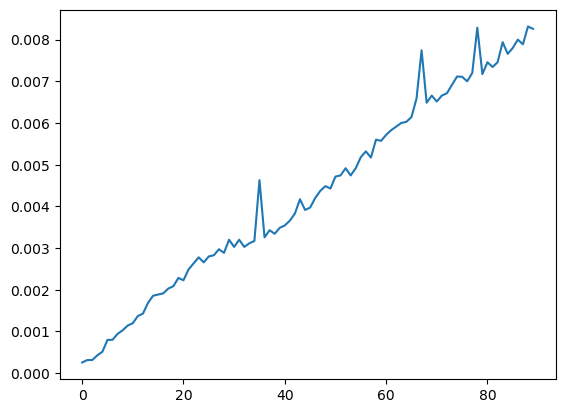

In [47]:
from matplotlib import pyplot as plt

plt.plot(time_fasta_algorithm(stop_length=900, step_length=10))
plt.show()

## Smith Waterman Algorithm Time Analysis

In [28]:
from utils.stringutils import find_most_similar_substring_naive
import time, random, tqdm, numpy as np

def time_smith_waterman_algorithm(start_length=0, stop_length=2000, step_length=1, batch_length=35, corpus=corpus):
    times = []
    for length in tqdm.tqdm(range(start_length, stop_length, step_length)):
        sub_times = []
        for _ in range(batch_length):
            start_pos = random.randint(0, len(corpus) - length)
            substring = corpus[start_pos:start_pos + length]
            start = time.time()
            best_match, best_score = find_most_similar_substring_naive(corpus, substring)
            end = time.time()
            sub_times.append(end - start)
        times.append(np.mean(sub_times))
    return times

100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


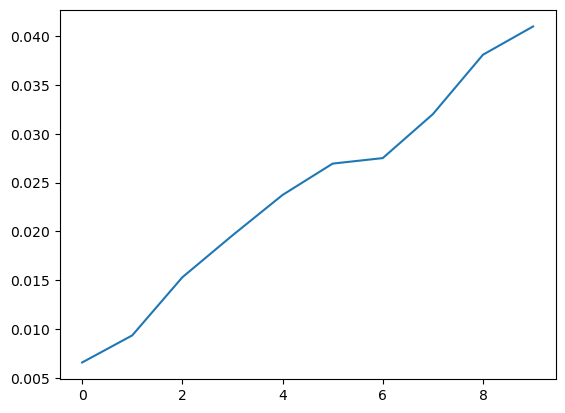

In [29]:
from matplotlib import pyplot as plt

plt.plot(time_smith_waterman_algorithm(stop_length=100, step_length=10))
plt.show()